In [1]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import seaborn as sns 

In [2]:
ticker = 'AAPL'
start = '2017-11-17'
end = '2022-11-01'

In [3]:
stock_data = yf.download(ticker, start, end, adjusted=True)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-17,42.759998,42.847500,42.410000,42.537498,40.448887,87598000
2017-11-20,42.572498,42.639999,42.389999,42.494999,40.408474,65049600
2017-11-21,42.695000,43.424999,42.695000,43.285000,41.159698,100525200
2017-11-22,43.340000,43.750000,43.262501,43.740002,41.592358,102355600
2017-11-24,43.775002,43.875000,43.662498,43.742500,41.594727,56106800


In [4]:
ff_monthly = gff.famaFrench3Factor(frequency='m')
ff_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff_monthly.set_index('Date', inplace=True)
ff_monthly.tail()

,Mkt-RF,SMB,HML,RF
Date,,,,
2022-05-31,-0.0034,-0.0185,0.0841,0.0003
2022-06-30,-0.0843,0.0209,-0.0597,0.0006
2022-07-31,0.0957,0.0281,-0.0410,0.0008
2022-08-31,-0.0378,0.0139,0.0031,0.0019
2022-09-30,-0.0936,-0.0081,0.0005,0.0019


In [5]:
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = "Month_Rtn"
ff_data = ff_monthly.merge(stock_returns,on='Date')
ff_data.tail()

,Mkt-RF,SMB,HML,RF,Month_Rtn
Date,,,,,
2022-05-31,-0.0034,-0.0185,0.0841,0.0003,-0.054496
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,-0.081430
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.188634
2022-08-31,-0.0378,0.0139,0.0031,0.0019,-0.031208
2022-09-30,-0.0936,-0.0081,0.0005,0.0019,-0.120977


In [6]:
X = ff_data[['Mkt-RF', 'SMB', 'HML']]
y = ff_data['Month_Rtn'] - ff_data['RF']
X = sm.add_constant(X)
ff_model = sm.OLS(y, X).fit()
print(ff_model.summary())
intercept, b1, b2, b3 = ff_model.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     24.57
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           3.68e-10
Time:                        20:09:39   Log-Likelihood:                 81.378
No. Observations:                  58   AIC:                            -154.8
Df Residuals:                      54   BIC:                            -146.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0146      0.008      1.783      0.0

In [7]:
x_capm = ff_data[['Mkt-RF']]
y_capm = ff_data['Month_Rtn'] - ff_data['RF']
X_capm = sm.add_constant(x_capm)
ff_model_capm = sm.OLS(y_capm, X_capm).fit()
print(ff_model_capm.summary())
intercept_capm, b1_capm = ff_model_capm.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     60.15
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           1.95e-10
Time:                        20:09:39   Log-Likelihood:                 77.569
No. Observations:                  58   AIC:                            -151.1
Df Residuals:                      56   BIC:                            -147.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0161      0.009      1.884      0.0

In [9]:
intercept_capm

0.016117275540456805

In [10]:
b1_capm

1.2035336215156007

In [11]:
mkt_rf = .61
hml = .38
smb = .25
rf = .33

In [12]:
capm_exreturn = rf + (mkt_rf*b1_capm)
(1+(capm_exreturn/100))**12-1

0.13544425346150768

In [13]:
ff_exreturn = rf + (mkt_rf*b1)+(smb*b2)+(hml*b3)
(1+(ff_exreturn/100))**12-1

0.1048334225332681

<AxesSubplot:xlabel='Mkt-RF', ylabel='Month_Rtn'>

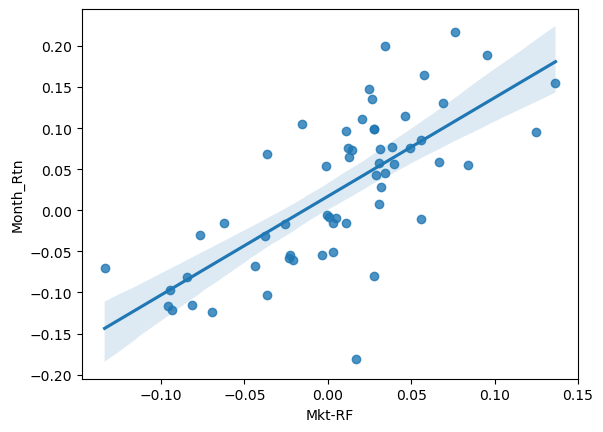

In [14]:
sns.regplot(data = ff_data, x = 'Mkt-RF', y='Month_Rtn' )